# Generative AI Text Classification

In [226]:
# imports

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from openai import OpenAI
import os
from dotenv import load_dotenv
import s3fs
import fs_s3fs
import fsspec
import json
from llama_index.core import TreeIndex, SimpleDirectoryReader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import keras
import transformers
import mlflow
import hyperopt as hp
import sphinx
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from tensorflow.keras.optimizers import SGD

In [2]:
# download stopwords

#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
newStopwords = ['b','lt','gt','n','u','ap','reuters'] # Add stopwords 

for stopword in newStopwords:
    stopwords.append(stopword)

In [ ]:
stopwords

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# Download dataset from Kaggle

dataset = "https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset/data"
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

In [20]:
# Read dataset, import only 30000 rows of data

df = pd.read_csv(r'C:\Users\nickr\OneDrive\Documents\GitHub\generative-ai-text-summarization\data\ag-news-classification-dataset\ag_news.csv',nrows=30000)

In [21]:
# Check shape of dataframe

df.shape

(30000, 3)

In [22]:
# Confirm importation

df.head(8)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,3,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,3,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...


In [23]:
# Confirm shape

df.shape

(30000, 3)

In [24]:
# Drop Description column

df = df.drop('Description',axis=1)

# Data Cleaning and Preprocessing

In [25]:
# find null values and datatypes

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  30000 non-null  int64 
 1   Title        30000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1 MB


There are no null values in the df dataset.

In [30]:
# check for duplicates

df.duplicated().sum()

1354

There are 1354 duplicate values in the df dataset.

In [118]:
# Drop duplicates

df = df.drop_duplicates()

In [31]:
# Cleaning data set html, special, and non-textual characters

def cleaning_text(text):
    # Remove HTML tags
    cleaning_text = re.sub('<.*?>', '', text)
    # Remove special characters and non-textual 
    cleaning_text = re.sub(r'([^a-zA-Z\s]|\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', ' ', cleaning_text) # checks plain text for given characters
    return cleaning_text

In [32]:
# apply text cleaning to text in both Description and Title

df['Title'] = df['Title'].apply(cleaning_text)

In [33]:
# Check that the function worked

df.head(7)

,Class Index,Title
0,3,Wall St Bears Claw Back Into the Black Reuters
1,3,Carlyle Looks Toward Commercial Aerospace Reu...
2,3,Oil and Economy Cloud Stocks Outlook Reuters
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Oil prices soar to all time record posing new...
5,3,Stocks End Up But Near Year Lows Reuters
6,3,Money Funds Fell in Latest Week AP


Note that in this data set, 1 represents World News, 2 represents Sports News, 3 represents Business News, and 4 represents Sci/Tech news

In [34]:
# Create a function to remove stop words

stop_words = set(stopwords)
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercasing
    tokens = [word for word in tokens if word not in stop_words]  # Stop word removal
    return ' '.join(tokens)

In [35]:
# apply preprocessing to text in Title

df['Title'] = df['Title'].apply(preprocess_text)

In [ ]:
# Check that the function worked

df.head(7)

In [ ]:
# convert to CSV for ease of use in future

cleaned_data_file = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned\cleaned_ag_news.csv'
df.to_csv(cleaned_data_file, index=False)

# Data Splitting

In [120]:
# Split training data into training and validation data 

df_train, df_val = train_test_split(df, test_size=.15, random_state=42)

In [ ]:
# Create csv file for train and test data

df_train.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'train.csv'), index=False)
df_test.to_csv(os.path.join(r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\ag_news_cleaned', 'test.csv'), index=False)

In [ ]:
# Create feature data directory

feature_data_dir = r'C:\Users\nickr\OneDrive\Desktop\CapstoneTechX\features'
os.makedirs(feature_data_dir, exist_ok=True)

In [121]:
# TF-IDF Vectorization for Title

tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # we can play around with this. This was an arbitrary value
train_title_features = tfidf_vectorizer.fit_transform(df_train['Title'])
test_title_features = tfidf_vectorizer.transform(df_test['Title'])

In [ ]:
# look at one of the matrices the vectorizer produces

# print(df_train['Title'][98])
# print(train_title_features.toarray()[98]) 

Note, the vectorizer produces a value for a specific word on a scale of 0 to 1. The closer the number is to 1, the more unique that word is.

In [122]:
# Print our features

features = tfidf_vectorizer.get_feature_names_out()
print(tfidf_vectorizer.vocabulary_, end=' ')

{'businesses': 355, 'rise': 2218, 'july': 1393, 'sales': 2275, 'schumacher': 2301, 'finishes': 962, 'second': 2323, 'spa': 2484, 'still': 2542, 'claims': 481, 'seventh': 2375, 'season': 2319, 'might': 1644, 'europe': 850, 'oil': 1797, 'us': 2817, 'expansion': 870, 'sears': 2318, 'begins': 234, 'selling': 2340, 'home': 1229, 'online': 1806, 'protest': 2048, 'benefit': 240, 'cuts': 631, 'de': 651, 'medal': 1609, 'charter': 444, 'add': 22, 'phone': 1914, 'service': 2363, 'firms': 969, 'build': 347, 'anti': 102, 'missile': 1660, 'defense': 674, 'jets': 1373, 'sign': 2414, 'carter': 402, 'jones': 1384, 'fails': 894, 'win': 2935, 'long': 1528, 'jump': 1394, 'relay': 2158, 'groups': 1132, 'work': 2960, 'stop': 2545, 'hurricanes': 1267, 'bonds': 296, 'hits': 1216, 'giants': 1084, 'rout': 2247, 'google': 1106, 'ipo': 1339, 'threat': 2683, 'due': 777, 'shortage': 2399, 'bids': 251, 'inflation': 1305, 'slips': 2443, 'per': 1900, 'cent': 419, 'predict': 2001, 'higher': 1202, 'dollar': 743, 'dips':

In [123]:
# Confirm feature number

print(len(features))

3000


In [124]:
# Save the TF-IDF feature matrices

#pd.DataFrame(train_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_desc_features.csv'), index=False)
#pd.DataFrame(test_desc_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_desc_featuress.csv'), index=False)
#pd.DataFrame(train_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'train_title_features.csv'), index=False)
#pd.DataFrame(test_title_features.toarray()).to_csv(os.path.join(feature_data_dir, 'test_title_featuress.csv'), index=False)

# EDA

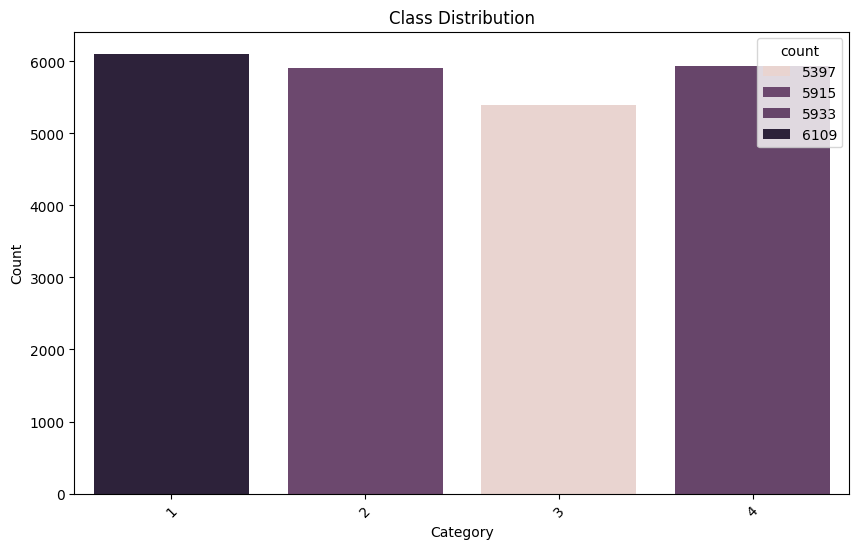

In [125]:
# Sum the counts of each index
class_counts = df_train['Class Index'].value_counts().reset_index()

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=class_counts, x='Class Index', y='count', hue='count')
plt.title('Class Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [126]:
# Summary statistics of class distribution

class_balance = class_counts.describe()
print("Class Balance:")
print(class_balance)

Class Balance:
       Class Index        count
count     4.000000     4.000000
mean      2.500000  5838.500000
std       1.290994   307.069482
min       1.000000  5397.000000
25%       1.750000  5785.500000
50%       2.500000  5924.000000
75%       3.250000  5977.000000
max       4.000000  6109.000000


Note that there is a fairly even distribution of categories in our training dataset. No further resampling techniques needed.

In [127]:
# Splitting dataframes by category

index_one = df_train['Class Index'] == 1
df_index_one = df_train[index_one]

index_two = df_train['Class Index'] == 2
df_index_two = df_train[index_two]

index_three = df_train['Class Index'] == 3
df_index_three = df_train[index_three]

index_four = df_train['Class Index'] == 4
df_index_four = df_train[index_four]

In [128]:
# Gather most common words for category World News

index_list_one = ' '.join(df_index_one['Title']).split()
word_counts_one = Counter(index_list_one)
one_common_words = word_counts_one.most_common(30)
print("\nWorld News - Most Common Words:")
print(one_common_words)


World News - Most Common Words:
[('afp', 382), ('iraq', 351), ('us', 275), ('says', 217), ('bush', 204), ('talks', 175), ('new', 166), ('najaf', 164), ('killed', 156), ('china', 144), ('sudan', 140), ('iraqi', 137), ('darfur', 134), ('russia', 131), ('kerry', 130), ('un', 123), ('pakistan', 122), ('peace', 119), ('bomb', 118), ('press', 118), ('attack', 112), ('korea', 110), ('terror', 109), ('canadian', 108), ('kills', 106), ('dead', 106), ('iran', 102), ('nuclear', 102), ('two', 97), ('israel', 95)]


In [129]:
# Gather most common words for category Sports News

index_list_two = ' '.join(df_index_two['Title']).split()
word_counts_two = Counter(index_list_two)
two_common_words = word_counts_two.most_common(30)
print("\nSports News - Most Common Words:")
print(two_common_words)


Sports News - Most Common Words:
[('gold', 286), ('us', 268), ('win', 233), ('wins', 200), ('open', 148), ('cup', 138), ('team', 133), ('game', 111), ('olympic', 110), ('olympics', 109), ('back', 101), ('new', 97), ('yankees', 95), ('sox', 95), ('games', 94), ('world', 94), ('medal', 93), ('first', 91), ('final', 88), ('women', 86), ('lead', 81), ('takes', 81), ('top', 77), ('athens', 77), ('hewitt', 75), ('england', 70), ('men', 70), ('ryder', 68), ('federer', 67), ('beat', 66)]


In [130]:
# Gather most common words for category Business News

index_list_three = ' '.join(df_index_three['Title']).split()
word_counts_three = Counter(index_list_three)
three_common_words = word_counts_three.most_common(30)
print("\nBusiness News - Most Common Words:")
print(three_common_words)


Business News - Most Common Words:
[('oil', 441), ('us', 359), ('stocks', 277), ('update', 261), ('prices', 206), ('profit', 189), ('new', 144), ('sales', 139), ('says', 130), ('shares', 115), ('may', 114), ('dollar', 111), ('rise', 110), ('google', 110), ('fall', 101), ('deal', 100), ('growth', 99), ('jobs', 98), ('bank', 95), ('price', 94), ('higher', 90), ('cuts', 90), ('china', 85), ('cut', 84), ('data', 84), ('buy', 83), ('talks', 82), ('opec', 81), ('airways', 80), ('economy', 71)]


In [131]:
# Gather most common words for category Sci/Tech News

index_list_four = ' '.join(df_index_four['Title']).split()
word_counts_four = Counter(index_list_four)
four_common_words = word_counts_four.most_common(30)
print("\nSci/Tech News - Most Common Words:")
print(four_common_words)


Sci/Tech News - Most Common Words:
[('new', 348), ('microsoft', 339), ('ibm', 186), ('intel', 160), ('com', 159), ('space', 133), ('apple', 133), ('internet', 126), ('windows', 120), ('linux', 114), ('mobile', 109), ('software', 108), ('world', 108), ('phone', 104), ('google', 102), ('may', 101), ('security', 100), ('pc', 99), ('oracle', 93), ('hp', 90), ('service', 89), ('web', 88), ('music', 85), ('sp', 85), ('online', 81), ('study', 76), ('xp', 76), ('says', 74), ('deal', 74), ('chip', 73)]


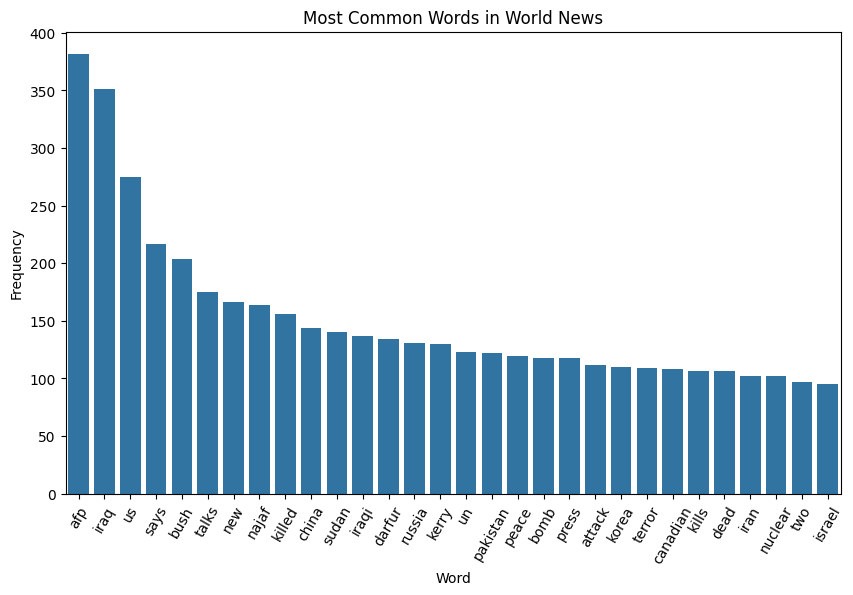

In [132]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in one_common_words], y=[word[1] for word in one_common_words])
plt.title('Most Common Words in World News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

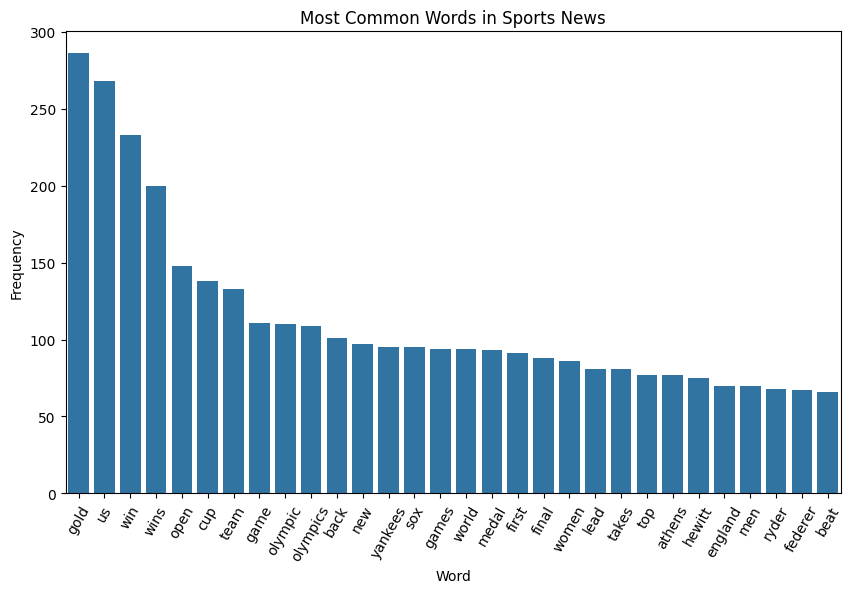

In [133]:
# Vizualize word frequency for Business News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in two_common_words], y=[word[1] for word in two_common_words])
plt.title('Most Common Words in Sports News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

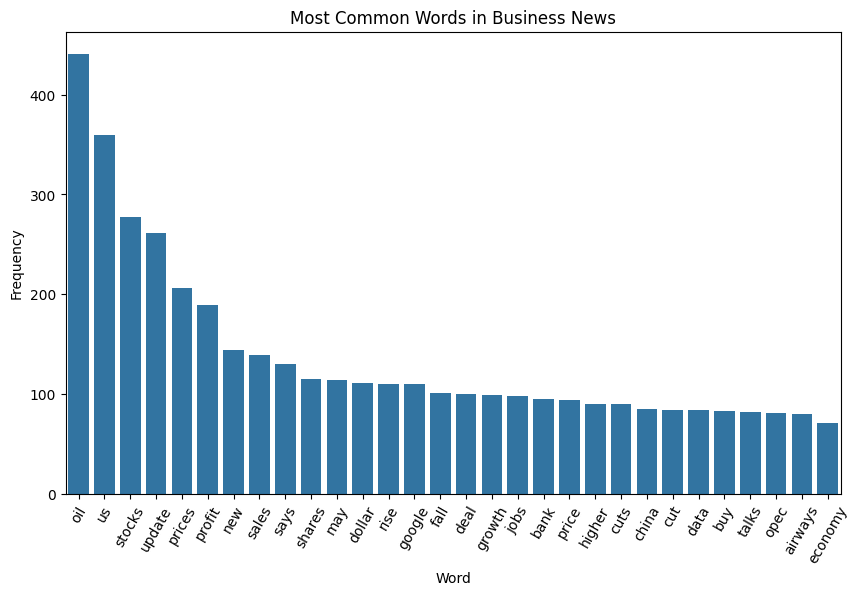

In [134]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in three_common_words], y=[word[1] for word in three_common_words])
plt.title('Most Common Words in Business News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

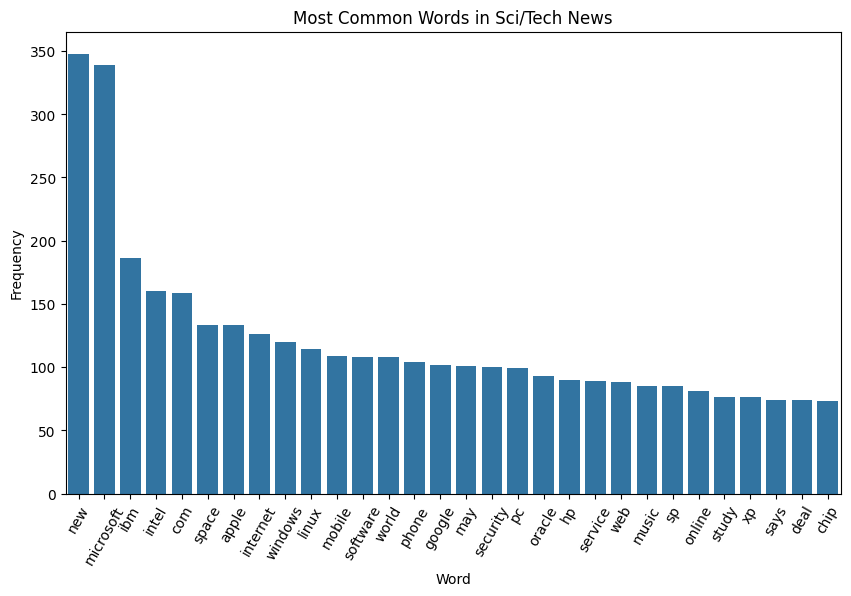

In [135]:
# Vizualize word frequency for World News

plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in four_common_words], y=[word[1] for word in four_common_words])
plt.title('Most Common Words in Sci/Tech News')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=60)
plt.show()

In [136]:
# Get title lengths for each row
df_train['Title Length'] = df_train['Title'].apply(lambda x: len(x.split()))
print(df_train['Title Length'])

# Modifying df_test for future use
df_test['Title Length'] = df_test['Title'].apply(lambda x: len(x.split()))

28375    5
13813    8
13216    5
11196    4
8205     5
        ..
23529    5
5862     6
897      8
17222    4
25798    8
Name: Title Length, Length: 23354, dtype: int64


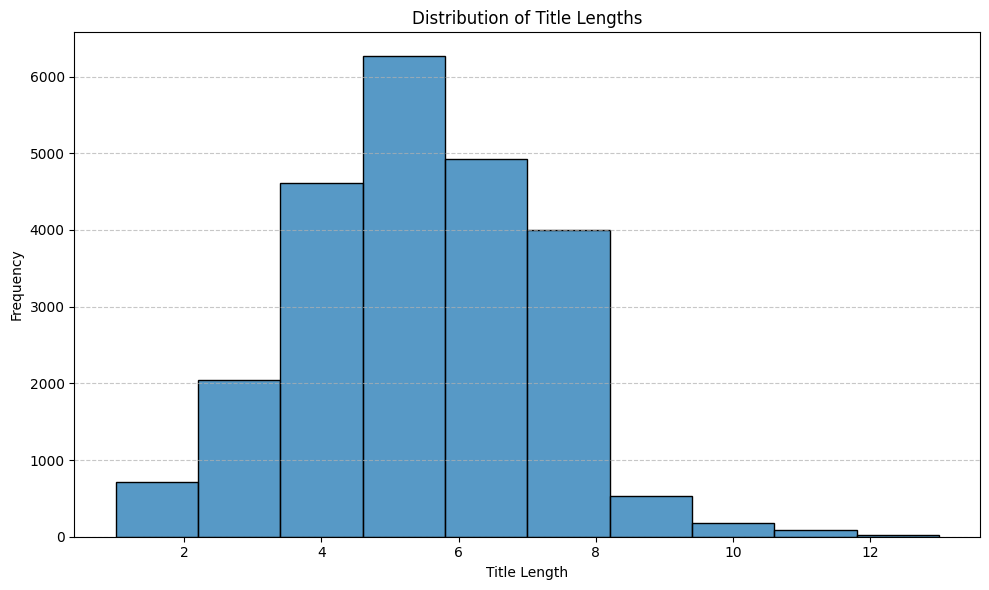

In [137]:
# Title length analysis

plt.figure(figsize=(10, 6))
sns.histplot(df_train['Title Length'], bins=10)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Note that the distribution of our title lengths is right-skew

In [138]:
#get TF IDF values as a dataframe

tfidf_df = pd.DataFrame(train_title_features.toarray())

In [139]:
# Transform matrix to array, flatten, and removes zeros

tfidf_df = train_title_features.toarray().flatten()
tfidf_df = tfidf_df[tfidf_df != 0]

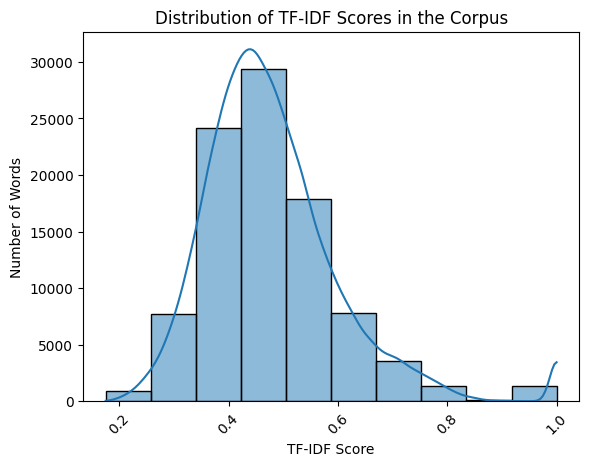

In [140]:
# Distribution of non-zero TF-IDF Scores

sns.histplot(tfidf_df, bins=10, kde=True)
plt.xlabel("TF-IDF Score")
plt.ylabel("Number of Words")
plt.title("Distribution of TF-IDF Scores in the Corpus")
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for long feature names
plt.show()

Note that our TF IDF distribution is right skew

In [141]:
from feature_engine.outliers import Winsorizer

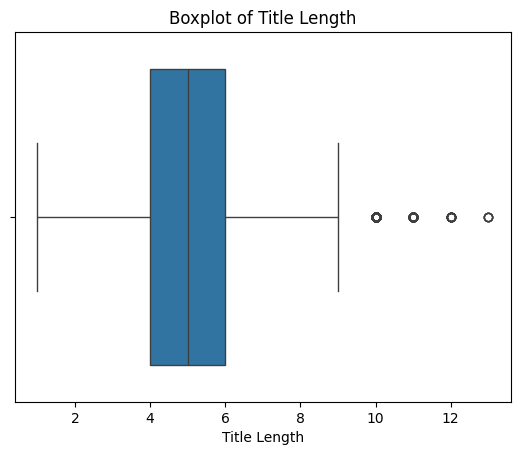

In [142]:
# Plot boxplot to find skewness

sns.boxplot(df_train['Title Length'], orient='h')
plt.xlabel("Title Length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()

Confirms previous image indicating right skewness

In [143]:
# Winsorize the text length to handle outliers

capper = Winsorizer(capping_method='gaussian', tail='right', fold=2)
capper.fit(df_train)

Winsorizer(fold=2)

In [144]:
capper.right_tail_caps_

{'Class Index': 4.741015823434227, 'Title Length': 8.555226238490478}

In [145]:
train_t = capper.transform(df_train)
test_t = capper.transform(df_test)

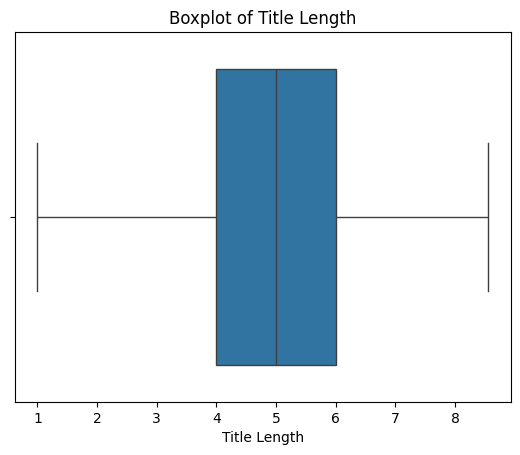

In [146]:
sns.boxplot(train_t['Title Length'], orient='h')
plt.xlabel("Title Length")
plt.title("Boxplot of Title Length")  # Optional: Rotate x-axis labels for long feature names
plt.show()

Outliers are no longer present in dataset

# Transformer Model Architecture

In [147]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

In [250]:
# Positional Encoding
def get_positional_encoding(seq_length, d_model):
    positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    angle_rads = positions * angle_rates
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return pos_encoding


def transformer_block(x, num_heads, d_model, dff, rate, training):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = Dropout(rate)(attn_output, training=training)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn_output = Dense(dff, activation='relu')(out1)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = Dropout(rate)(ffn_output, training=training)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


# Build the Transformer Model for Text Classification
def build_model(max_len_input, vocab_size, num_heads=8, d_model=128, dff=512, rate=0.1):
    # Input
    inputs = Input(shape=(max_len_input,), name="input")
    embedding = Embedding(vocab_size, d_model, name="embedding")(inputs)
    pos_encoding = get_positional_encoding(max_len_input, d_model)
    embedding += pos_encoding

    # Transformer Encoder
    encoder_output = embedding
    for _ in range(4):
        encoder_output = transformer_block(encoder_output, num_heads, d_model, dff, rate, training=True)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(encoder_output)

    # Output layer
    outputs = Dense(1, activation="sigmoid")(pooled_output)  # Binary classification, use sigmoid activation

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])  # Binary classification, use binary_crossentropy

    return model

# Parameters
max_len_input = 100
vocab_size = 10000

# Create the model
model = build_model(max_len_input, vocab_size)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 100, 128)          │       1,280,000 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_18 (Add)                  │ (None, 100, 128)          │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_8        │ (None, 100, 128)          │         527,488 │ add_18[0][0], add_18[0][0] │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_25 (Dropout)          │ (None, 100, 128)          │               0 │ multi_head_attention_8[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_19 (Add)                  │ (None, 100, 128)          │               0 │ add_18[0][0],              │
│                               │                           │                 │ dropout_25[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_16        │ (None, 100, 128)          │             256 │ add_19[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 100, 512)          │          66,048 │ layer_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 100, 128)          │          65,664 │ dense_18[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_26 (Dropout)          │ (None, 100, 128)          │               0 │ dense_19[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_20 (Add)                  │ (None, 100, 128)          │               0 │ layer_normalization_16[0]… │
│                               │                           │                 │ dropout_26[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_17        │ (None, 100, 128)          │             256 │ add_20[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_9        │ (None, 100, 128)          │         527,488 │ layer_normalization_17[0]… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_17[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_28 (Dropout)          │ (None, 100, 128)          │               0 │ multi_head_attention_9[0]… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,918,977 (14.95 MB)

 Trainable params: 3,918,977 (14.95 MB)

 Non-trainable params: 0 (0.00 B)

In [251]:
def preprocess_data(input_text, tokenizer, max_len_input):
    # Tokenize and encode input text
    input_ids = tokenizer.encode(input_text, max_length=max_len_input, truncation=True)
    input_ids_padded = input_ids + [0] * (max_len_input - len(input_ids))  # Pad sequences
    return input_ids_padded
    
def predict_class(input_text, tokenizer, model, max_len_input):
    input_ids_padded = preprocess_data(input_text, tokenizer, max_len_input)
    # Convert input to tensor
    input_ids_tensor = tf.convert_to_tensor([input_ids_padded])
    # Predict using the model
    outputs = model(input_ids_tensor)
    predicted_class = tf.argmax(outputs[0]).numpy()
    return predicted_class

predicted_class = predict_class("The US is in running out of oil", tokenizer, model, max_len_input)
print(predicted_class)

0


In [254]:
from transformers import BertForMaskedLM, BertTokenizer, TrainingArguments, TFBertForTokenClassification
from keras.losses import SparseCategoricalCrossentropy
import tftrainer
import torch
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from torch import cuda
from datasets import Dataset

In [151]:
df_test = df_test.drop(['Title Length'], axis=1)

In [152]:
df_train = df_train.drop(['Title Length'], axis=1)

In [247]:
df_train = df_train.rename(columns = {'Title':'text'}, inplace = True)
df_test = df_test.rename(columns = {'Title':'text'}, inplace = True)

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [281]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", problem_type="multi_label_classification").to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [282]:
# Example DistilBert

inputs = tokenizer("Hello, my dog is cute", padding='longest', return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

In [283]:
# Print logits

(logits)

tensor([[ 0.1498, -0.0246]])

In [284]:
# Print predicted class IDs

predicted_class_ids = torch.arange(0, logits.shape[-1])[torch.sigmoid(logits).squeeze(dim=0) > 0.5]
print(predicted_class_ids)

tensor([0])


In [285]:
labels = torch.sum(
    torch.nn.functional.one_hot(predicted_class_ids[None, :].clone(), num_classes=4), dim=1
).to(torch.float)
loss = model(**inputs, labels=labels).loss

ValueError: Target size (torch.Size([1, 4])) must be the same as input size (torch.Size([1, 2]))

In [260]:
labels

tensor([[1., 1., 1., 0.]])

In [261]:
loss

tensor(0.6480, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
from datasets import Dataset

In [249]:
hugging_train = Dataset.from_pandas(train_dataset)
hugging_val = Dataset.from_pandas(df_test)

AttributeError: 'NoneType' object has no attribute 'columns'

In [ ]:
hugging_train

In [216]:
hugging_val

Dataset({
    features: ['Class Index', 'Title', '__index_level_0__'],
    num_rows: 4122
})

In [217]:
def preprocess_function(examples):
    """
    Tokenize the text to create input and attention data
    
    in -> dataset (columns = text, label)
    out -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["Title"], truncation=True)

In [219]:
tokenized_train = hugging_train.map(preprocess_function, batched=True)
tokenized_val = hugging_val.map(preprocess_function, batched=True)

Map: 100%|███████████████████████████████████████████████████████████████| 4122/4122 [00:00<00:00, 87515.80 examples/s]


In [189]:
tokenized_val.shape

(4122, 5)

In [220]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [237]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=1e-5,               
    logging_dir='./logs',            
    eval_steps=100,
)

trainer = transformers.Trainer(model=model,
                args=training_args,
                train_dataset=tokenized_train,
                eval_dataset=tokenized_val,
                tokenizer=tokenizer,
                data_collator=data_collator, 
                compute_metrics='sparsecategoricalcrossentropy',
                #compute_loss='sparsecategoricalcrossentropy',
                #optimizers='SGD')
                              )

In [238]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)